# IT3100 - Model Conversion
## Background
I trained a SKU object detection model using TF Model Garden's ResNet50 backbone. The output was a Tensorflow Saved Model with a size of over 100mb. The size made it difficult to deploy.
## Purpose
Convert my current model to a smaller format, while preserving accuracy and improving portability.
## Implementation
Use Open Neural Network Exchange (ONNX) libraries to convert my Tensorflow Saved Model to their more portable ONNX format. Then, quantize the ONNX model to reduce it's size to under 100mb.
## Steps
1. Convert model to ONNX
2. Quantize ONNX model to \<100mb

## Disclaimer
*This notebook was developed in Google Colab, you may alter the code to run locally or in other environments, mainly the saving/loading of models/datasets.*

# Mount Google Drive
If running locally, skip this step.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install dependencies
I am using numpy 1.26.4 as versions 2.0.0 onwards are not compatible with tf2onnx.

When running the below code cell, it will request to restart session. Click the button to restart the session and continue from here.

In [1]:
!pip install tf2onnx numpy==1.26.4 onnxruntime

# Importing libraries

In [30]:
import onnxruntime as ort
import numpy as np
import tensorflow as tf
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import ImageDraw
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

# Convert saved model to ONNX
Change paths according to your file structure.

In [ ]:
!python -m tf2onnx.convert --saved-model /content/drive/MyDrive/exported_object_detection_model --output /content/drive/MyDrive/model.onnx

# Check file size

In [2]:
!ls -lh /content/drive/MyDrive/model.onnx

-rw------- 1 root root 201M Aug 10 09:39 /content/drive/MyDrive/model.onnx


It may be larger than original model, but that is okay as we will quantize it later.

# Load test image from URL

In [35]:
image_url = "https://www.packaging-gateway.com/wp-content/uploads/sites/16/2024/03/packaging-shelf-appeal-shutterstock_1219556386.jpg"  # Example image
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")
image = image.resize((640, 640))
input1 = np.array(image, dtype=np.uint8)  # Shape: (640, 640, 3)
input1 = np.expand_dims(input1, axis=0)   # Shape: (1, 640, 640, 3)

# Save original size


In [16]:
orig_width, orig_height = image.size

# ONNX model inference

In [56]:
sess = ort.InferenceSession("/content/drive/MyDrive/model.onnx")
results_ort = sess.run(None, {"inputs": input1})

# TensorFlow model inference


In [7]:
model = tf.saved_model.load("/content/drive/MyDrive/exported_object_detection_model")
results_tf = model.signatures['serving_default'](tf.constant(input1))

# Convert TF results to list of numpy arrays

In [8]:
results_tf_list = [results_tf[key].numpy() for key in ['detection_boxes', 'detection_classes', 'detection_scores', 'image_info', 'num_detections']]

# Compare results

In [9]:
for ort_res, tf_res in zip(results_ort, results_tf_list):
    np.testing.assert_allclose(ort_res, tf_res, rtol=1e-5, atol=1e-5)

print("Results match")

Results match


# Display TF Saved Model results

In [10]:
print("Detection boxes:", results_tf_list[0])
print("Detection classes:", results_tf_list[1])
print("Detection scores:", results_tf_list[2])
print("Image info:", results_tf_list[3])
print("Number of detections:", len(results_tf_list[2][0]))

Detection boxes: [[[127.8875     231.17828    185.72932    254.72841   ]
  [127.0791     558.67676    185.36624    582.24585   ]
  [205.69202    231.95364    264.4938     254.49284   ]
  [206.15742    559.3703     265.54156    581.9491    ]
  [128.98271    206.24355    186.89134    228.44058   ]
  [207.76897    320.1457     264.09564    341.27344   ]
  [128.592      533.9671     186.23965    556.1025    ]
  [208.38123    206.56955    265.23196    228.11293   ]
  [206.2293     343.84302    265.01636    365.7379    ]
  [128.99736    584.13477    184.93538    603.6742    ]
  [207.12239    256.4339     263.69946    275.44424   ]
  [129.2284     256.0308     185.93799    275.89038   ]
  [207.96938    534.2391     265.58652    555.9929    ]
  [139.02962    412.29593    188.49908    433.36212   ]
  [138.74165     84.20811    188.96994    105.44203   ]
  [128.37798    321.29532    186.31544    341.50534   ]
  [207.23946    583.7161     263.714      602.68445   ]
  [207.64351    277.81836    26

# Display ONNX model results

In [11]:
print("Detection boxes:", results_ort[0])
print("Detection classes:", results_ort[1])
print("Detection scores:", results_ort[2])
print("Image info:", results_ort[3])
print("Number of detections:", results_ort[4])

Detection boxes: [[[127.8875     231.17828    185.72932    254.72841   ]
  [127.0791     558.67676    185.36624    582.24585   ]
  [205.69203    231.95364    264.4938     254.49284   ]
  [206.15742    559.3703     265.54156    581.9491    ]
  [128.9827     206.24355    186.89133    228.44058   ]
  [207.76898    320.1457     264.09564    341.27344   ]
  [128.59201    533.9671     186.23967    556.1025    ]
  [208.38123    206.56955    265.23196    228.11293   ]
  [206.2293     343.84302    265.01636    365.7379    ]
  [128.99736    584.13477    184.93538    603.6742    ]
  [207.12239    256.4339     263.69946    275.44424   ]
  [129.2284     256.0308     185.938      275.89038   ]
  [207.96939    534.2391     265.58655    555.99286   ]
  [139.02962    412.29593    188.49908    433.36212   ]
  [138.74165     84.2081     188.96994    105.442024  ]
  [128.37798    321.29532    186.31544    341.50534   ]
  [207.23946    583.7161     263.714      602.68445   ]
  [207.64351    277.81836    26

# Visualise bounding boxes

## TF Saved Model

231 127 254 185
558 127 582 185
231 205 254 264
559 206 581 265
206 128 228 186
320 207 341 264
533 128 556 186
206 208 228 265
343 206 365 265
584 128 603 184
256 207 275 263
256 129 275 185
534 207 555 265
412 139 433 188
84 138 105 188
321 128 341 186
583 207 602 263
277 207 298 263
344 127 365 186
436 140 456 188
436 219 455 266
300 208 318 263
279 406 303 472
605 207 626 265
319 397 342 470
300 129 318 185
83 217 104 268
108 140 127 188
412 218 432 268
278 128 298 185
234 512 257 573
280 512 301 573
108 219 126 267
562 408 585 470
605 128 625 185
562 513 584 571
281 303 300 368
41 140 59 189
369 220 388 267
320 292 342 368
321 507 342 571
234 406 258 472
236 303 257 369
344 520 364 571
369 141 385 187
180 132 202 187
62 140 82 188
260 306 278 368
41 219 61 268
183 211 203 266
563 304 585 367
390 139 409 187
586 513 605 572
586 409 606 471
39 395 59 467
607 409 628 471
258 409 278 471
131 65 145 107
458 63 472 107
509 131 529 187
366 290 386 365
608 306 628 368
119 65 132 107
587 3

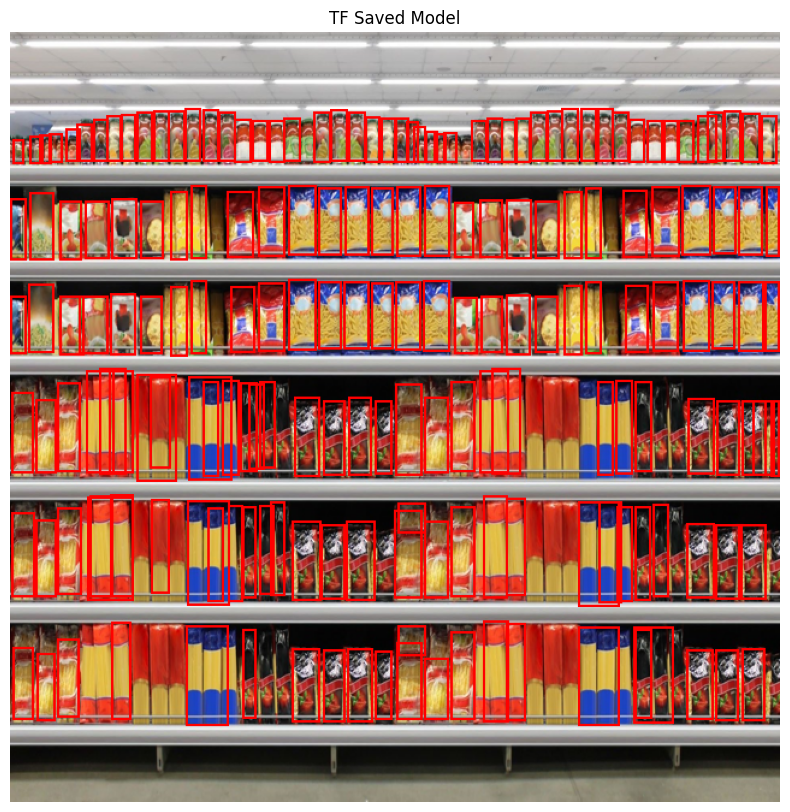

In [52]:
detection_boxes = results_tf['detection_boxes'].numpy()[0]   # [N, 4]
detection_classes = results_tf['detection_classes'].numpy()[0]
detection_scores = results_tf['detection_scores'].numpy()[0]

image = Image.open(BytesIO(response.content)).convert("RGB")
image = image.resize((640, 640))
new_image = image
draw = ImageDraw.Draw(new_image)
scale_x = orig_width / 640
scale_y = orig_height / 640
for box, cls, score in zip(detection_boxes, detection_classes, detection_scores):
    if score < 0.3:
        print('skip')
        continue  # Skip low confidence
    # print(box, cls, score)
    ymin, xmin, ymax, xmax = box  # Assuming normalized coords in [0,1]
    left = int(xmin * scale_x)
    top = int(ymin * scale_y)
    right = int(xmax * scale_x)
    bottom = int(ymax * scale_y)
    print(left, top, right, bottom)
    draw.rectangle([left, top, right, bottom], outline="red", width=2)


# Show annotated new_image in Colab/Jupyter
plt.figure(figsize=(10, 10))
plt.title("TF Saved Model")
plt.imshow(new_image)
plt.axis("off")
plt.show()

## ONNX

231 127 254 185
558 127 582 185
231 205 254 264
559 206 581 265
206 128 228 186
320 207 341 264
533 128 556 186
206 208 228 265
343 206 365 265
584 128 603 184
256 207 275 263
256 129 275 185
534 207 555 265
412 139 433 188
84 138 105 188
321 128 341 186
583 207 602 263
277 207 298 263
344 127 365 186
436 140 456 188
436 219 455 266
300 208 318 263
279 406 303 472
605 207 626 265
319 397 342 470
300 129 318 185
83 217 104 268
108 140 127 188
412 218 432 268
278 128 298 185
234 512 257 573
280 512 301 573
108 219 126 267
562 408 585 470
605 128 625 185
562 513 584 571
281 303 300 368
41 140 59 189
369 220 388 267
320 292 342 368
321 507 342 571
234 406 258 472
236 303 257 369
344 520 364 571
369 141 385 187
180 132 202 187
62 140 82 188
260 306 278 368
41 219 61 268
183 211 203 266
563 304 585 367
390 139 409 187
586 513 605 572
586 409 606 471
39 395 59 467
607 409 628 471
258 409 278 471
131 65 145 107
458 63 472 107
509 131 529 187
366 290 386 365
608 306 628 368
119 65 132 107
587 3

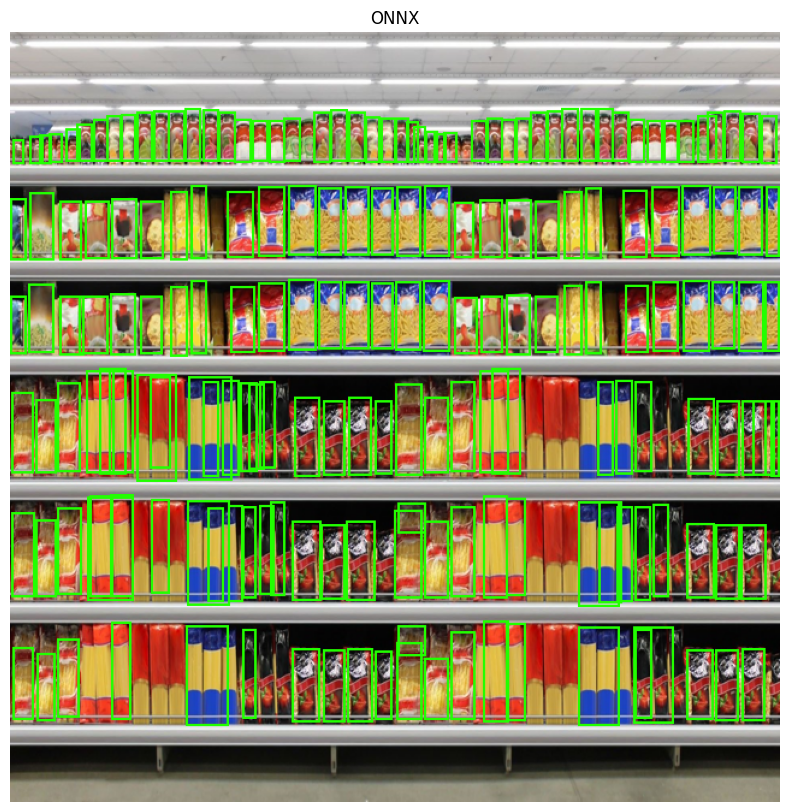

In [51]:
detection_boxes = results_ort[0][0]   # [N, 4]
detection_classes = results_ort[1][0]
detection_scores = results_ort[2][0]

image = Image.open(BytesIO(response.content)).convert("RGB")
image = image.resize((640, 640))
new_image = image
draw = ImageDraw.Draw(new_image)
scale_x = orig_width / 640
scale_y = orig_height / 640
for box, cls, score in zip(detection_boxes, detection_classes, detection_scores):
    if score < 0.3:
        print('skip')
        continue  # Skip low confidence
    # print(box, cls, score)
    ymin, xmin, ymax, xmax = box  # Assuming normalized coords in [0,1]
    left = int(xmin * scale_x)
    top = int(ymin * scale_y)
    right = int(xmax * scale_x)
    bottom = int(ymax * scale_y)
    print(left, top, right, bottom)
    draw.rectangle([left, top, right, bottom], outline="#22FF00", width=2)


# Show annotated new_image in Colab/Jupyter
plt.figure(figsize=(10, 10))
plt.title("ONNX")
plt.imshow(new_image)
plt.axis("off")
plt.show()

# Quantize ONNX model (without pre-processing)

In [31]:
model_fp32 = '/content/drive/MyDrive/model.onnx'
model_quant = '/content/drive/MyDrive/model.quant.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant)

In [32]:
!ls -lh /content/drive/MyDrive/model.quant.onnx

-rw------- 1 root root 55M Aug 15 15:08 /content/drive/MyDrive/model.quant.onnx


# Quantized ONNX model inference

In [55]:
sess = ort.InferenceSession("/content/drive/MyDrive/model.quant.onnx")
results_quant = sess.run(None, {"inputs": input1})

NotImplemented: [ONNXRuntimeError] : 9 : NOT_IMPLEMENTED : Could not find an implementation for ConvInteger(10) node with name 'StatefulPartitionedCall/res_net_2/conv2d_2/Conv2D_quant'

# Pre-process ONNX model for quantization

In [68]:
!python -m onnxruntime.quantization.preprocess --input /content/drive/MyDrive/model.onnx --output /content/drive/MyDrive/model_infer.onnx --skip_symbolic_shape SKIP_SYMBOLIC_SHAPE

# Quantize ONNX model (with pre-processing)

In [69]:
model_fp32 = '/content/drive/MyDrive/model_infer.onnx'
model_quant = '/content/drive/MyDrive/model_quant.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant)

# Quantized ONNX model inference

In [73]:
sess = ort.InferenceSession("/content/drive/MyDrive/model_quant.onnx" )
results_quant = sess.run(None, {"inputs": input1})

NotImplemented: [ONNXRuntimeError] : 9 : NOT_IMPLEMENTED : Could not find an implementation for ConvInteger(10) node with name 'StatefulPartitionedCall/res_net_2/conv2d_2/Conv2D_quant'

# Compare results with TF

In [53]:
for quant_res, tf_res in zip(results_quant, results_tf_list):
    np.testing.assert_allclose(quant_res, tf_res, rtol=1e-5, atol=1e-5)

print("Results match")

NameError: name 'results_quant' is not defined

# Define a data reader for static quantization

In [83]:
class DataReader(ort.quantization.CalibrationDataReader):
    def __init__(self, model_path: str):
        self.enum_data_dicts = []
        # In this example, we will use the same input data 'input1' for calibration.
        # For a real-world scenario, you should use a representative dataset.
        model = onnx.load(model_path)
        input_name = model.graph.input[0].name
        self.enum_data_dicts.append({input_name: input1})

    def get_next(self) -> dict:
        if self.enum_data_dicts:
            return self.enum_data_dicts.pop(0)
        else:
            return None

# Perform static quantization

In [85]:
model_fp32 = '/content/drive/MyDrive/model_infer.onnx'
model_quant_static = '/content/drive/MyDrive/model_quant_static.onnx'

# Create a data reader for calibration
dr = DataReader(model_fp32)

# Perform static quantization
ort.quantization.quantize_static(
    model_fp32,
    model_quant_static,
    dr,
    quant_format=ort.quantization.QuantFormat.QDQ,
    activation_type=ort.quantization.QuantType.QInt8,
    weight_type=ort.quantization.QuantType.QInt8,
    per_channel=True
)

print(f"Statically quantized model saved to: {model_quant_static}")

Statically quantized model saved to: /content/drive/MyDrive/model_quant_static.onnx


# Check statically quantized model file size

In [86]:
!ls -lh /content/drive/MyDrive/model_quant_static.onnx

-rw------- 1 root root 56M Aug 15 16:37 /content/drive/MyDrive/model_quant_static.onnx


# Statically quantized ONNX model inference

In [87]:
sess_quant_static = ort.InferenceSession("/content/drive/MyDrive/model_quant_static.onnx")
results_quant_static = sess_quant_static.run(None, {"inputs": input1})

# Compare statically quantized results with TF

In [88]:
for quant_static_res, tf_res in zip(results_quant_static, results_tf_list):
    np.testing.assert_allclose(quant_static_res, tf_res, rtol=1e-2, atol=1e-2) # Increased tolerance for quantization effects

print("Results match (with increased tolerance)")

AssertionError: 
Not equal to tolerance rtol=0.01, atol=0.01

Mismatched elements: 925 / 1000 (92.5%)
Max absolute difference: 611.8761
Max relative difference: 717.9776
 x: array([[[208.17085 , 559.3024  , 265.85675 , 579.36707 ],
        [127.91222 , 228.23552 , 185.59811 , 253.31635 ],
        [127.91222 , 559.3024  , 185.59811 , 579.36707 ],...
 y: array([[[127.8875  , 231.17828 , 185.72932 , 254.72841 ],
        [127.0791  , 558.67676 , 185.36624 , 582.24585 ],
        [205.69202 , 231.95364 , 264.4938  , 254.49284 ],...

# Visualize statically quantized bounding boxes

559 208 579 265
228 127 253 185
559 127 579 185
230 208 255 265
210 130 228 188
531 130 556 185
210 208 228 263
321 210 341 263
531 208 556 263
346 208 366 265
255 208 275 263
436 137 456 188
295 210 316 263
321 398 343 466
581 127 601 183
82 135 102 188
581 208 601 263
255 130 275 185
321 130 341 188
40 137 57 190
411 137 431 190
295 130 316 185
278 208 295 263
606 208 627 263
433 220 451 265
278 406 298 469
346 127 366 185
107 137 125 188
77 218 97 265
371 220 388 265
321 293 343 371
278 127 295 183
107 220 125 265
606 130 627 185
42 220 62 270
411 220 431 270
233 509 260 571
509 130 529 185
178 130 198 185
233 406 258 469
564 408 586 469
280 511 298 571
321 506 341 571
280 308 298 373
233 305 255 373
185 130 203 188
346 519 366 571
541 72 556 107
371 137 386 185
178 213 198 265
564 308 586 373
368 401 383 466
586 408 604 469
564 511 581 571
461 62 474 107
65 137 85 188
388 137 411 188
371 290 388 366
40 401 60 466
443 62 456 107
225 70 243 107
17 208 35 263
258 308 278 373
609 411 6

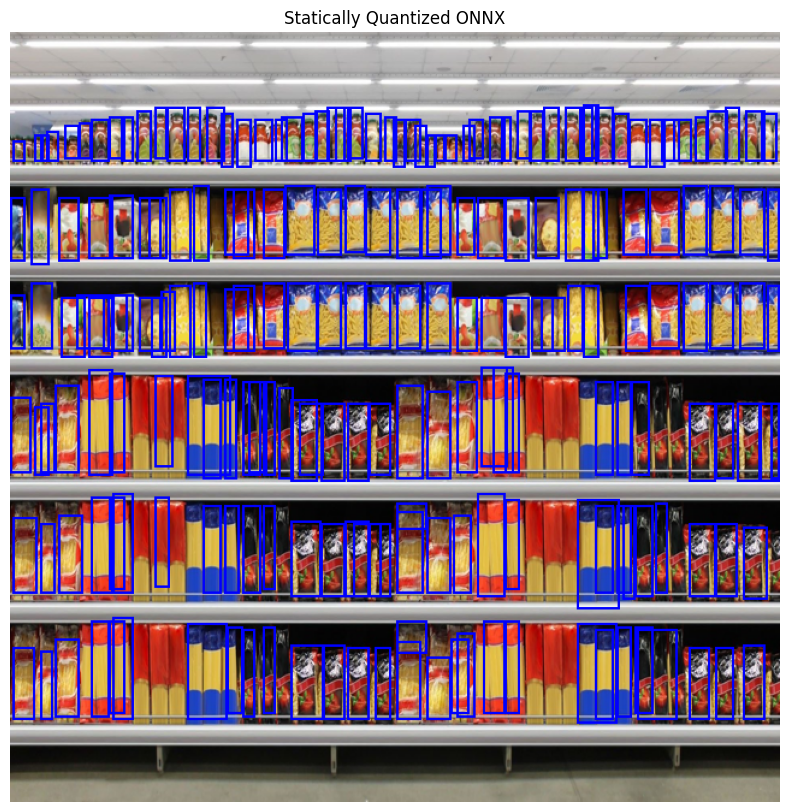

In [89]:
detection_boxes = results_quant_static[0][0]   # [N, 4]
detection_classes = results_quant_static[1][0]
detection_scores = results_quant_static[2][0]

image = Image.open(BytesIO(response.content)).convert("RGB")
image = image.resize((640, 640))
new_image = image
draw = ImageDraw.Draw(new_image)
scale_x = orig_width / 640
scale_y = orig_height / 640
for box, cls, score in zip(detection_boxes, detection_classes, detection_scores):
    if score < 0.3:
        print('skip')
        continue  # Skip low confidence
    # print(box, cls, score)
    ymin, xmin, ymax, xmax = box  # Assuming normalized coords in [0,1]
    left = int(xmin * scale_x)
    top = int(ymin * scale_y)
    right = int(xmax * scale_x)
    bottom = int(ymax * scale_y)
    print(left, top, right, bottom)
    draw.rectangle([left, top, right, bottom], outline="#0000FF", width=2) # Blue boxes

# Show annotated new_image in Colab/Jupyter
plt.figure(figsize=(10, 10))
plt.title("Statically Quantized ONNX")
plt.imshow(new_image)
plt.axis("off")
plt.show()

# Load a new test image from URL for quantized model inference

In [102]:
new_image_url = "https://media.istockphoto.com/id/1412238893/photo/spaghetti-pasta-fusilli-lasagna-packagings-on-shelf-at-supermarket-3d-illustration.jpg?s=612x612&w=0&k=20&c=kpU6rRZn5_KnsIroyka05xc-RiTkiRx43JERRN2UFnM=" # Replace with your desired image URL
response_new = requests.get(new_image_url)
image_new = Image.open(BytesIO(response_new.content)).convert("RGB")
orig_width_new, orig_height_new = image_new.size
image_new_resized = image_new.resize((640, 640))
input_new = np.array(image_new_resized, dtype=np.uint8)  # Shape: (640, 640, 3)
input_new = np.expand_dims(input_new, axis=0)   # Shape: (1, 640, 640, 3)

# Statically quantized ONNX model inference on new image

In [103]:
# Ensure the session for the statically quantized model is still available
# If not, recreate it:
# sess_quant_static = ort.InferenceSession("/content/drive/MyDrive/model_quant_static.onnx")

results_quant_static_new = sess_quant_static.run(None, {"inputs": input_new})

# Visualize statically quantized bounding boxes on new image

52 81 83 124
386 82 414 122
91 141 119 184
414 144 448 189
376 202 410 246
446 206 474 246
474 203 508 246
318 267 350 316
446 275 477 318
412 276 446 319
474 275 508 319
513 143 544 187
242 203 271 246
546 206 575 246
549 147 573 186
297 143 330 187
448 143 482 187
213 146 239 186
4 205 47 246
230 267 268 318
57 19 88 66
117 82 148 124
417 84 441 125
119 143 148 187
410 206 443 248
546 280 573 318
146 27 172 66
182 84 208 124
112 25 143 66
318 35 342 68
88 82 115 125
91 203 117 245
510 203 544 246
203 15 232 68
151 84 179 124
292 82 321 124
55 147 86 184
350 22 381 66
354 267 381 316
381 273 410 318
266 273 292 318
119 203 146 246
215 203 242 246
177 280 203 319
26 81 52 124
242 143 268 186
266 144 292 186
575 92 601 125
575 147 604 184
71 276 107 319
175 20 203 66
211 82 237 125
484 144 513 189
23 147 52 186
239 82 266 124
544 92 573 124
575 278 601 316
522 23 554 71
23 20 50 68
462 27 491 71
151 206 172 246
191 208 211 246
510 276 544 318
268 203 294 246
292 273 321 316
443 84 460 1

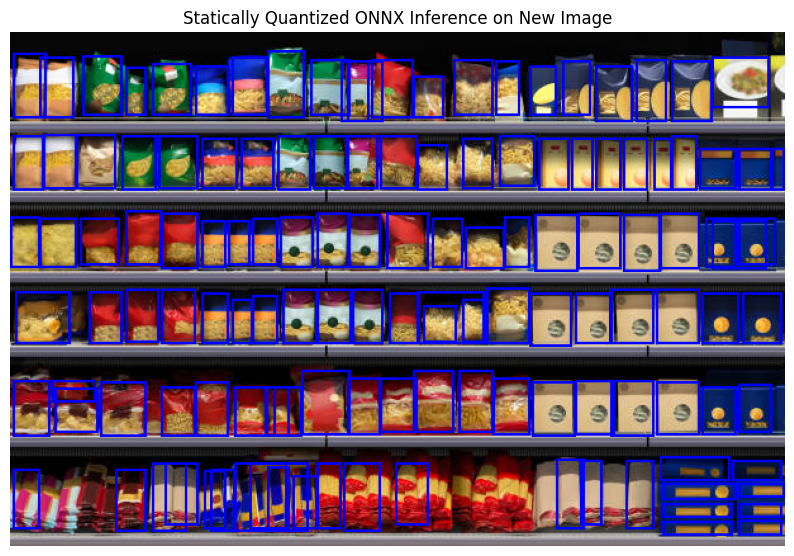

In [104]:
detection_boxes_new = results_quant_static_new[0][0]   # [N, 4]
detection_classes_new = results_quant_static_new[1][0]
detection_scores_new = results_quant_static_new[2][0]

image_to_draw = Image.open(BytesIO(response_new.content)).convert("RGB") # Use the original image for drawing
draw_new = ImageDraw.Draw(image_to_draw)
scale_x_new = orig_width_new / 640
scale_y_new = orig_height_new / 640

for box, cls, score in zip(detection_boxes_new, detection_classes_new, detection_scores_new):
    if score < 0.3:
        print('skip')
        continue  # Skip low confidence
    ymin, xmin, ymax, xmax = box  # Assuming normalized coords in [0,1]
    left = int(xmin * scale_x_new)
    top = int(ymin * scale_y_new)
    right = int(xmax * scale_x_new)
    bottom = int(ymax * scale_y_new)
    print(left, top, right, bottom)
    draw_new.rectangle([left, top, right, bottom], outline="#0000FF", width=2) # Blue boxes

# Show annotated new_image in Colab/Jupyter
plt.figure(figsize=(10, 10))
plt.title("Statically Quantized ONNX Inference on New Image")
plt.imshow(image_to_draw)
plt.axis("off")
plt.show()

# TensorFlow model inference on new image

In [105]:
model = tf.saved_model.load("/content/drive/MyDrive/exported_object_detection_model")
results_tf_new_image = model.signatures['serving_default'](tf.constant(input_new))

# ONNX model inference on new image

In [106]:
sess = ort.InferenceSession("/content/drive/MyDrive/model.onnx")
results_ort_new_image = sess.run(None, {"inputs": input_new})

# Visualize bounding boxes on new image (TF vs ONNX)

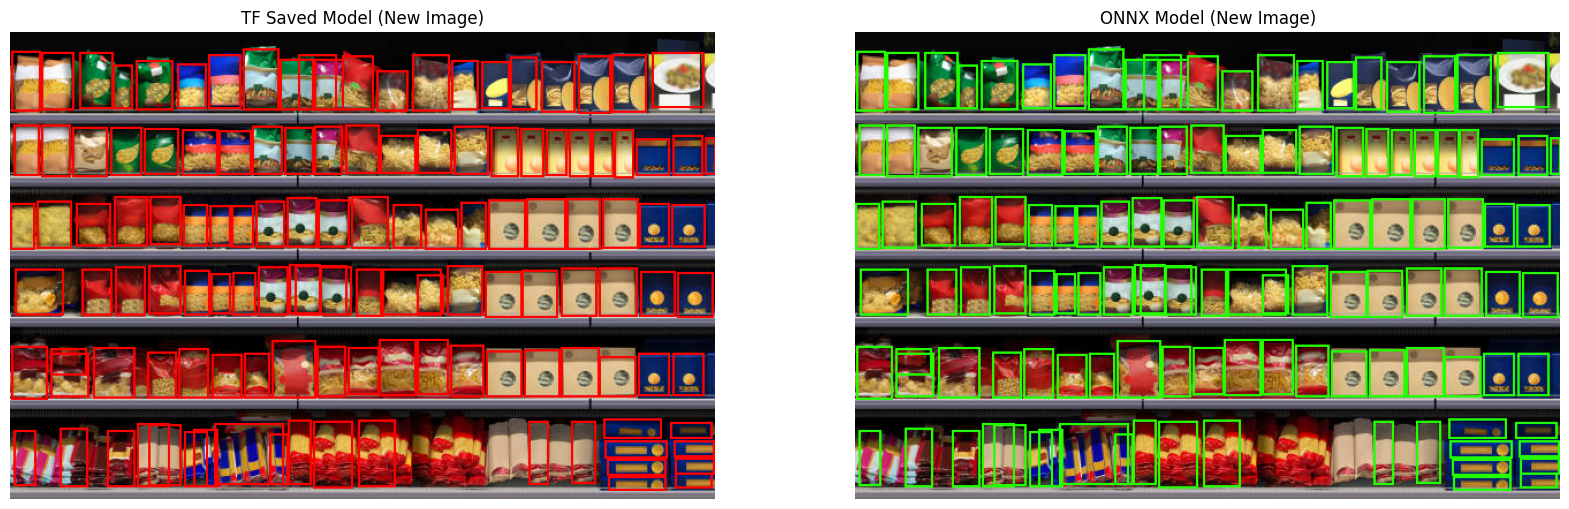

In [107]:
# TF Saved Model results on new image
detection_boxes_tf_new = results_tf_new_image['detection_boxes'].numpy()[0]
detection_classes_tf_new = results_tf_new_image['detection_classes'].numpy()[0]
detection_scores_tf_new = results_tf_new_image['detection_scores'].numpy()[0]

# ONNX model results on new image
detection_boxes_ort_new = results_ort_new_image[0][0]
detection_classes_ort_new = results_ort_new_image[1][0]
detection_scores_ort_new = results_ort_new_image[2][0]


image_tf_viz_new = Image.open(BytesIO(response_new.content)).convert("RGB")
image_ort_viz_new = Image.open(BytesIO(response_new.content)).convert("RGB")

draw_tf_new = ImageDraw.Draw(image_tf_viz_new)
draw_ort_new = ImageDraw.Draw(image_ort_viz_new)

scale_x_new_viz = orig_width_new / 640
scale_y_new_viz = orig_height_new / 640

# Draw boxes for TF Saved Model
for box, cls, score in zip(detection_boxes_tf_new, detection_classes_tf_new, detection_scores_tf_new):
    if score < 0.3:
        continue
    ymin, xmin, ymax, xmax = box
    left = int(xmin * scale_x_new_viz)
    top = int(ymin * scale_y_new_viz)
    right = int(xmax * scale_x_new_viz)
    bottom = int(ymax * scale_y_new_viz)
    draw_tf_new.rectangle([left, top, right, bottom], outline="red", width=2)

# Draw boxes for ONNX model
for box, cls, score in zip(detection_boxes_ort_new, detection_classes_ort_new, detection_scores_ort_new):
    if score < 0.3:
        continue
    ymin, xmin, ymax, xmax = box
    left = int(xmin * scale_x_new_viz)
    top = int(ymin * scale_y_new_viz)
    right = int(xmax * scale_x_new_viz)
    bottom = int(ymax * scale_y_new_viz)
    draw_ort_new.rectangle([left, top, right, bottom], outline="#22FF00", width=2) # Green boxes


# Show annotated images side-by-side
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("TF Saved Model (New Image)")
plt.imshow(image_tf_viz_new)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("ONNX Model (New Image)")
plt.imshow(image_ort_viz_new)
plt.axis("off")

plt.show()

# Compare number of detections with confidence > 0.3

In [108]:
# Get detection scores for each model on the new image
detection_scores_tf_new = results_tf_new_image['detection_scores'].numpy()[0]
detection_scores_ort_new = results_ort_new_image[2][0]
detection_scores_quant_static_new = results_quant_static_new[2][0]

# Count detections with confidence > 0.3
count_tf = np.sum(detection_scores_tf_new > 0.3)
count_ort = np.sum(detection_scores_ort_new > 0.3)
count_quant_static = np.sum(detection_scores_quant_static_new > 0.3)

print(f"Number of detections with confidence > 0.3 for TF Saved Model: {count_tf}")
print(f"Number of detections with confidence > 0.3 for original ONNX model: {count_ort}")
print(f"Number of detections with confidence > 0.3 for statically quantized ONNX model: {count_quant_static}")

Number of detections with confidence > 0.3 for TF Saved Model: 128
Number of detections with confidence > 0.3 for original ONNX model: 128
Number of detections with confidence > 0.3 for statically quantized ONNX model: 132
